# **PROYECTO HUMOR** Modelo Binario con Red Feedforward

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [3]:
# Importación de librerias de python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# NLTK (Natural Language Toolkit): Procesamiento de texto y tokenización
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

# Gensim: Modelos de aprendizaje profundo para texto (Word2Vec)
from gensim.models import Word2Vec

# Scikit-learn: División de datos y otras utilidades para machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# TensorFlow / Keras: Construcción y entrenamiento de redes neuronales
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model

# Conexión con drive para obtener el dataset
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Carga de los datos**

Primero, se extraen los 10000 datos chistosos y los otros 10000 datos no chistosos. En total son 20000 registros.

In [4]:
url_graceful_dataset = '/content/drive/MyDrive/proyecto NLP/humor_dataset.csv'
url_non_graceful_dataset = '/content/drive/MyDrive/proyecto NLP/datosNochistosos.csv'

df_graceful = pd.read_csv(url_graceful_dataset)
df_non_graceful = pd.read_csv(url_non_graceful_dataset)

dataset = pd.concat([df_graceful, df_non_graceful])
dataset['Es_gracioso'] = dataset['Es_gracioso'].fillna(0)

# Se muestra 5 ejemplos aleatorios del dataset donde la columna "Es_gracioso" indica si es chistoso o no.
print(dataset.shape)
dataset.sample(n=3)

(20000, 20)


,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
7177,tweet10812,"RT DichoDeLaAbuela: Porrazo no es desconsuelo,...",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
6705,6706,Mañana es lunes\nMañana es lune\nMañana es lun...,Internet/Twitter,0.0,1.0,1.0,1.0,0.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3100,tweet4731,Con sus besos cura to mis males\n#CIENMDELOCA,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


## **2. Preprocesamiento de los datos**

Segundo, para el preprocesamiento usamos varios pasos. Primero se reemplazan URLs, menciones de usuarios, hashtags y emojis por tokens genéricos (<URL'>, <USUARIO'>, <HASH_TAG'>, <EMOJI'>), lo que reduce la dimensionalidad del texto sin perder contexto. Además, se convierte todo a minúsculas para uniformidad, se eliminan signos de puntuación y nombres de archivos irrelevantes, y se tokeniza el texto en palabras individuales.

Por último, se eliminan stopwords (palabras comunes como "y" o "el") para reducir ruido y mantener solo términos relevantes. El resultado es una lista de palabras procesadas, lista para ser vectorizada y usada en el modelo, garantizando mayor consistencia y eficiencia.

In [5]:
def preprocess_text(text):
    # Transformación de las URLs a su token <URL>
    text = re.sub(r'http\S+', '<URL>', text)

    # Transformación de las menciones de usaurio a su token <USUARIO>
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Dejar en miniscula el texto
    text = text.lower()

    # Eliminar emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F'
                  r'\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F'
                  r'\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', '<EMOJI>', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transformación de los hashtags a su token <HASH_TAG>
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)

    # Transformación de las imagenes a su token <IMAGE>
    text = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>:", text)

    # Tokenizar texto en palabras
    tokens = word_tokenize(text)

    # Remover palabras de parada
    spanish_stopwords = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in spanish_stopwords]

    return tokens

dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset[['text', 'Es_gracioso']]
dataset.sample(n=3)

,text,Es_gracioso
4211,"[plato, favorito, abuela, siempre, lleva, ingr...",1.0
7932,"[usuario, comparando, url, url, sencillo, 50, ...",1.0
1771,"[usuario, realiza, vez, directo, paro]",0.0


## **3. Partición de los datos**

Tercero, se realiza una revisión de la distribuión de los datos para verificar un correcto balanceo de las clases.

In [6]:
"""
Función para graficar la distribución de los datos
"""
def graficar_distribucion(class_counts):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d", hue=class_counts.index)

    # Añadir los números sobre las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title("Distribución de Clases en el Conjunto de Datos")
    plt.xlabel("Clase")
    plt.ylabel("Número de Muestras")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)
    plt.show()

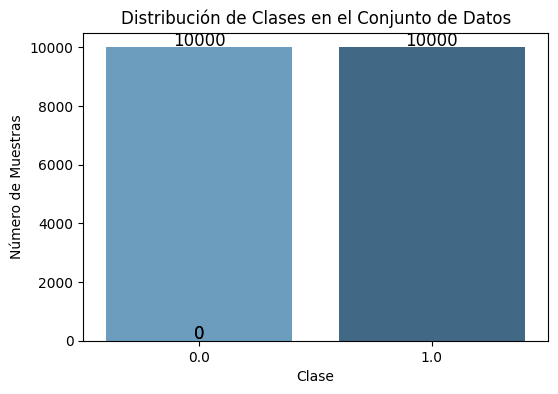

In [7]:
# Distribución de los datos de cada clase
graficar_distribucion(dataset['Es_gracioso'].value_counts())

Una vez verificado el correcto balanceo de las clase, se hace la partición de los datos dejando un 70% de los datos para entrenamiento, un 15% de los datos para validación y un 15% de los datos para prueba.

In [8]:
# Divide el dataset original en un cojunto entrenamiento y un conjunto auxliar
X_train, X_aux, y_train, y_aux = train_test_split(
    dataset['text'],
    dataset['Es_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=dataset['Es_gracioso']
)

# Divide el conjunto auxiliar en un cojunto de prueba y un cojunto de validación
X_val, X_test, y_val, y_test = train_test_split(
    X_aux,
    y_aux,
    random_state=2024,
    test_size=0.5,
    stratify=y_aux
)

Ahora se entrena un modelo Word2Vec con las frases tokenizadas de `X_train`, generando vectores de 100 dimensiones para cada palabra, considerando un contexto de 5 palabras (`window=5`) y excluyendo términos con menos de 2 apariciones (`min_count=2`).

Luego, `most_similar('gracioso')` verifica qué palabras tienen una representación vectorial cercana a "gracioso", mostrando relaciones semánticas aprendidas y permitiendo evaluar la calidad del modelo.

In [9]:
# Entrenar el modelo Word2Vec
w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=2, workers=4)
print(w2v_model.wv.most_similar('gracioso'))

[('lpm', 0.9930505752563477), ('realmente', 0.9929037690162659), ('video', 0.9926632642745972), ('repente', 0.9926460981369019), ('rato', 0.9925892949104309), ('frío', 0.9925808310508728), ('realidad', 0.9925773739814758), ('suenan', 0.9925665855407715), ('verano', 0.9924861192703247), ('pasado', 0.9924807548522949)]


Después creamos una función que transforma textos en vectores promediados utilizando el modelo Word2Vec. La función `text_to_vector` toma los tokens de un texto y calcula el promedio de sus vectores generados por `Word2Vec`. Si no hay palabras conocidas en el texto, devuelve un vector de ceros.

Luego, aplica esta función a los conjuntos de datos `X_train`, `X_val` y `X_test`, convirtiendo cada texto en un vector de tamaño fijo (100 dimensiones), listo para ser utilizado por el modelo de aprendizaje automático.

In [10]:
"""
Función para generar vectores promediados
"""
def text_to_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convertir textos a vectores
X_train_vec = np.array([text_to_vector(tokens, w2v_model, 100) for tokens in X_train])
X_val_vec = np.array([text_to_vector(tokens, w2v_model, 100) for tokens in X_val])
X_test_vec = np.array([text_to_vector(tokens, w2v_model, 100) for tokens in X_test])

## **4. Construcción y entrenamiento del modelo**

Cuarto, se realiza la definición del modelo feedforward diseñado para clasificación binaria, priorizando simplicidad y generalización.

* **Capa oculta 1:**  Tiene 128 neuronas con activación ReLU y un `Dropout` del 40% para prevenir sobreajuste, aprendiendo patrones iniciales de los datos.

* **Capa oculta 2:** Contiene 64 neuronas con ReLU y un `Dropout` del 30%, reduciendo la dimensionalidad y regularizando el aprendizaje.

* **Capa de salida:** Una neurona con activación sigmoidal que genera probabilidades para decidir entre las dos clases.

In [11]:
model = Sequential([
    # Capa oculta 1
    Dense(128, input_dim=100, activation='relu'),

    # Capa de Dropout
    Dropout(0.4),

    # Capa oculta 2
    Dense(64, activation='relu'),

    # Capa de Dropout
    Dropout(0.3),

    # Capa de salida
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


El modelo se compila con el optimizador Adam, la función de pérdida binary_crossentropy (adecuada para clasificación binaria) y la métrica accuracy para evaluar el rendimiento.

In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

Se definen los siguiente callbacks para el proceso de entrenamiento:

* **EarlyStopping:** Detiene el entrenamiento si la pérdida en validación (val_loss) no mejora después de 20 épocas.

* **ModelCheckpoint:** Guarda el mejor modelo basado en la pérdida mínima en validación (val_loss) en un archivo con el nombre especificado.

In [13]:
"""
Función para definir dos callbacks para el entranmiento (EarlyStopping y ModelCheckpoint)
"""
def callbacks_model():
  my_callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_loss"),
      tf.keras.callbacks.ModelCheckpoint("model.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
  ]

  return my_callbacks

Procedemos con el entrenamiento del modelo, definimos 100 epochs, un batch size de 32 y usamos la función de callback que definimos anteriormente.

In [14]:
history = model.fit(
    X_train_vec, y_train,
    validation_data=(X_val_vec, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_model()
)

Epoch 1/100
428/438 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5615 - loss: 0.6658
Epoch 1: val_loss improved from inf to 0.63227, saving model to model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5620 - loss: 0.6653 - val_accuracy: 0.6000 - val_loss: 0.6323
Epoch 2/100
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6070 - loss: 0.6238
Epoch 2: val_loss improved from 0.63227 to 0.62697, saving model to model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6070 - loss: 0.6238 - val_accuracy: 0.6117 - val_loss: 0.6270
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6127 - loss: 0.6202
Epoch 3: val_loss improved from 0.62697 to 0.61985, saving model to model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6127 - loss: 0.6202 - val_accuracy: 0.6163 - val_loss: 0.6198
Epoch 4/100
418/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6170 - loss: 0.6202
Epoch 4: val_loss did not improve from 0.61985
438/438 ━━━━━━━━━━

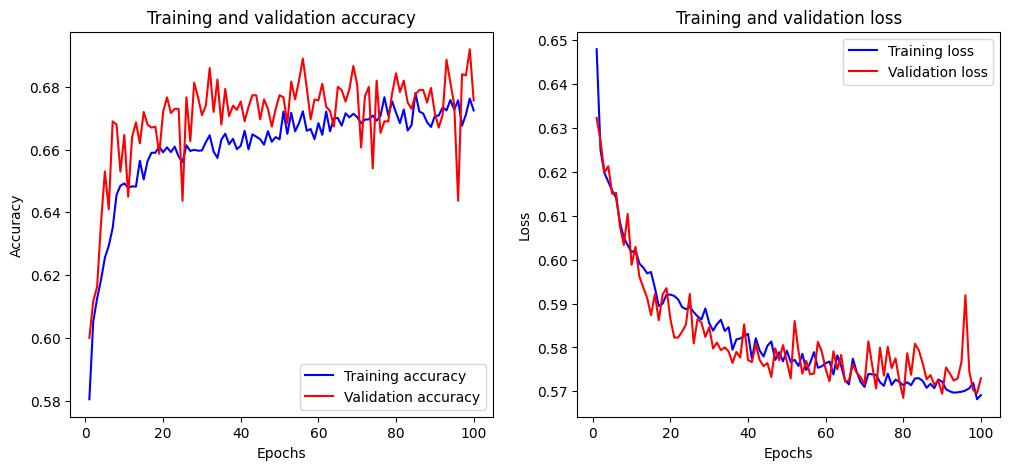

In [15]:
"""
Función para graficar los resultados del entramiento
"""
def plot_accuracy_and_loss(history):

    # Extraer datos de la historia de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Número de épocas
    epochs = range(1, len(acc) + 1)

    # Gráfica de accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfica de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_accuracy_and_loss(history)

Una vez terminado el entrenamiento se carga el mejor modelo guardado por el callback de ModelCheckpoint.

In [16]:
# Carga del mejor modelo
model = load_model('model.keras')

## **5. Resultados del modelo**

Quinto, se procede a calcular la matriz de confusión que arroja del modelo con respecto al conjunto de prueba. A partir de esta matriz, se derivan tres métricas importantes: precisión, recall y F1.

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Métricas derivadas de la matriz de confusión:
 - Precisión: 0.7684
 - Recall: 0.5373
 - F1: 0.6324


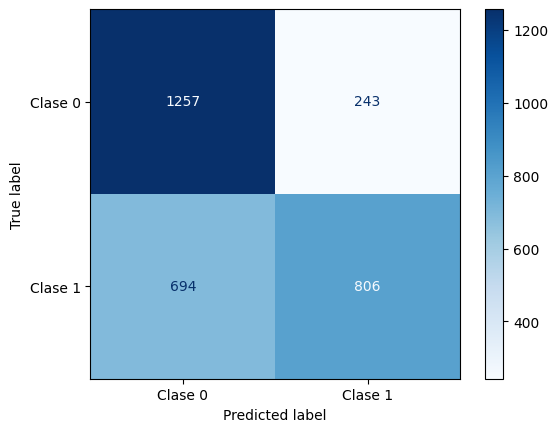

In [17]:
# Predecir etiquetas para el conjunto de prueba
y_pred = (model.predict(X_test_vec) > 0.5).astype("int32")

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")

# Calcular métricas adicionales basadas en la matriz de confusión
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar las métricas de la matriz de confusión
print("\nMétricas derivadas de la matriz de confusión:")
print(f" - Precisión: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1: {f1:.4f}")

El modelo binario muestra una precisión aceptable de 0.7684, indicando que las predicciones correctas son relativamente altas. Sin embargo, el recall de 0.5373 sugiere que el modelo tiene dificultades para identificar todas las instancias positivas (Clase 1), dejando una parte significativa sin detectar. El F1-score de 0.6324 refleja un equilibrio moderado entre precisión y recall, pero con margen de mejora. La matriz de confusión evidencia que hay un desbalance en la predicción, ya que muchas instancias de la Clase 1 son clasificadas incorrectamente como Clase 0.